In [1]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# seed
import os
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

In [2]:
data = pd.read_csv('005930_crawling.csv')
data = data[::-1]
data.reset_index(drop=True, inplace=True)
data

,Date,Close,YtT,Market Cap,High,Low,Volume
0,2010.08.11,779000.0,14000.0,784000.0,789000.0,777000.0,359968.0
1,2010.08.12,766000.0,13000.0,768000.0,777000.0,765000.0,428357.0
2,2010.08.13,781000.0,15000.0,770000.0,782000.0,767000.0,286706.0
3,2010.08.16,782000.0,1000.0,773000.0,783000.0,767000.0,205733.0
4,2010.08.17,782000.0,0.0,777000.0,783000.0,771000.0,289608.0
...,...,...,...,...,...,...,...
2462,2020.08.05,56900.0,400.0,57300.0,57500.0,56300.0,17739706.0
2463,2020.08.06,58000.0,1100.0,57100.0,58400.0,57100.0,21625874.0
2464,2020.08.07,57500.0,500.0,57900.0,58400.0,57100.0,18751717.0
2465,2020.08.10,57800.0,300.0,57600.0,58300.0,57500.0,17774291.0


In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
#scaler = StandardScaler()
scale_cols = ['Close', 'YtT', 'Market Cap', 'High', 'Low', 'Volume']
data_scaled = scaler.fit_transform(data[scale_cols])

data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = scale_cols

print(data_scaled)

TEST_SIZE = 200
train = data_scaled[:-TEST_SIZE]
test = data_scaled[-TEST_SIZE:]

         Close       YtT  Market Cap      High       Low    Volume
0     0.262630  0.099291    0.272696  0.274339  0.273784  0.005670
1     0.258026  0.092199    0.267130  0.270167  0.269556  0.006747
2     0.263339  0.106383    0.267826  0.271905  0.270261  0.004516
3     0.263693  0.007092    0.268870  0.272253  0.270261  0.003240
4     0.263693  0.000000    0.270261  0.272253  0.271670  0.004561
...        ...       ...         ...       ...       ...       ...
2462  0.006888  0.002837    0.019930  0.019993  0.019838  0.279405
2463  0.007278  0.007801    0.019861  0.020306  0.020120  0.340613
2464  0.007101  0.003546    0.020139  0.020306  0.020120  0.295344
2465  0.007207  0.002128    0.020035  0.020271  0.020261  0.279949
2466  0.007349  0.002837    0.020174  0.020688  0.020366  0.390058

[2467 rows x 6 columns]


In [4]:
train

,Close,YtT,Market Cap,High,Low,Volume
0,0.262630,0.099291,0.272696,0.274339,0.273784,0.005670
1,0.258026,0.092199,0.267130,0.270167,0.269556,0.006747
2,0.263339,0.106383,0.267826,0.271905,0.270261,0.004516
3,0.263693,0.007092,0.268870,0.272253,0.270261,0.003240
4,0.263693,0.000000,0.270261,0.272253,0.271670,0.004561
...,...,...,...,...,...,...
2262,0.004622,0.001418,0.017565,0.017594,0.017653,0.105548
2263,0.004409,0.004255,0.017496,0.017698,0.017495,0.133611
2264,0.004551,0.002837,0.017357,0.017524,0.017548,0.069404
2265,0.004870,0.006383,0.017670,0.017907,0.017865,0.171658


In [5]:
test

,Close,YtT,Market Cap,High,Low,Volume
2267,0.004693,0.003546,0.018261,0.018255,0.017794,0.333681
2268,0.004764,0.001418,0.017670,0.017803,0.017794,0.124110
2269,0.004905,0.002837,0.017635,0.017907,0.017865,0.101298
2270,0.004834,0.001418,0.017878,0.017976,0.017900,0.119412
2271,0.004586,0.004965,0.017635,0.017663,0.017689,0.141113
...,...,...,...,...,...,...
2462,0.006888,0.002837,0.019930,0.019993,0.019838,0.279405
2463,0.007278,0.007801,0.019861,0.020306,0.020120,0.340613
2464,0.007101,0.003546,0.020139,0.020306,0.020120,0.295344
2465,0.007207,0.002128,0.020035,0.020271,0.020261,0.279949


In [6]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
seq_len = 50
feature_cols = ['YtT', 'Market Cap', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, seq_len)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle=False)

print(x_train.shape,y_train.shape, x_valid.shape, y_valid.shape)

test_feature = test[feature_cols]
test_label = test[label_cols]

x_test, y_test = make_dataset(test_feature, test_label, seq_len)

print(x_test.shape, y_test.shape)

(1773, 50, 5) (1773, 1) (444, 50, 5) (444, 1)
(150, 50, 5) (150, 1)


In [8]:
def build_model(drop=0.5, optimizer = 'adam'):
    inputs = Input(shape= (seq_len,5), name = 'input')
    x = LSTM(128, activation = 'relu', name = 'hidden1', return_sequences=True)(inputs)
    x = Dropout(drop)(x)
    x = LSTM(64, activation = 'relu', name = 'hidden1')(inputs)
    x = Dropout(drop)(x)
    x = Dense(50, activation = 'relu', name = 'hidden2')(x)
    x = Dropout(drop)(x)
    x = Dense(30, activation = 'relu', name = 'hidden3')(x)
    x = Dropout(drop)(x)
    x = Dense(10, activation = 'relu', name = 'hidden4')(x)
    outputs = Dense(1, activation='linear', name = 'output')(x)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
    return model

In [9]:
model_p = build_model(0.2, 'adam')

In [10]:
model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 50, 5)]           0         
_________________________________________________________________
hidden1 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
hidden3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0     

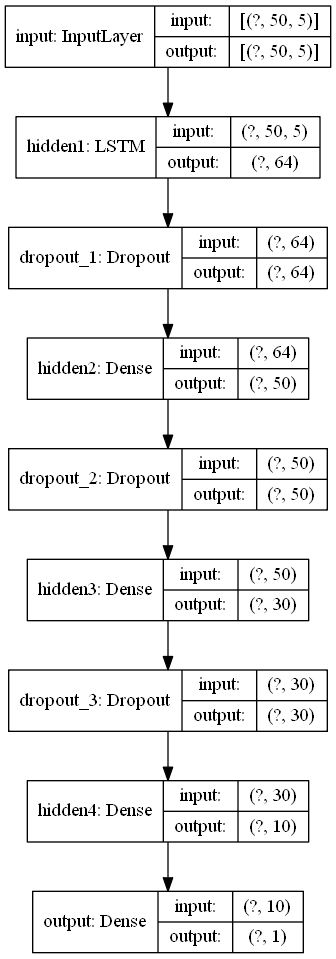

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model_p, show_shapes=True, to_file='lstm_stock.png')

In [12]:
# parameter
def create_hyperparameters(): # epochs, node, acivation 추가 가능
    batches = [8, 16, 32]
    optimizers = ['rmsprop', 'adam', 'adadelta']
    dropout = np.linspace(0.1, 0.5, 5).tolist()                           
    return {'batch_size' : batches, 'optimizer': optimizers, 
           'drop': dropout}

hyperparameters = create_hyperparameters()

In [13]:
# wrapper
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor          
model = KerasRegressor(build_fn = build_model, verbose = 2)

In [14]:
# gridsearch & randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# search = GridSearchCV(model, hyperparameters, cv = 3) # cv = cross_validation
search = RandomizedSearchCV(model, hyperparameters, cv = 3) #, n_jobs=5
# n_jobs = 사용할 core의 수를 정해줌
# batches * optimizers * dropout * cv
#   3     *     3      *    5    *  3 = 225번의 model이 돌아감

In [15]:
# fit
best_model = search.fit(x_train, y_train)
print(search.best_params_)

Train on 1182 samples
1182/1182 - 2s - loss: 0.2958 - mse: 0.2958
591/1 - 0s - loss: 0.2300 - mse: 0.1580
Train on 1182 samples
1182/1182 - 2s - loss: 0.3530 - mse: 0.3530
591/1 - 0s - loss: 0.1832 - mse: 0.1993
Train on 1182 samples
1182/1182 - 2s - loss: 0.2314 - mse: 0.2314
591/1 - 0s - loss: 0.6510 - mse: 0.4465
Train on 1182 samples
1182/1182 - 1s - loss: 0.0900 - mse: 0.0900
591/1 - 0s - loss: 0.0051 - mse: 0.0021
Train on 1182 samples
1182/1182 - 2s - loss: 0.1395 - mse: 0.1395
591/1 - 0s - loss: 0.0010 - mse: 0.0017
Train on 1182 samples
1182/1182 - 1s - loss: 0.0461 - mse: 0.0461
591/1 - 0s - loss: 0.1001 - mse: 0.0608
Train on 1182 samples
1182/1182 - 1s - loss: 0.0425 - mse: 0.0425
591/1 - 0s - loss: 0.0013 - mse: 0.0012
Train on 1182 samples
1182/1182 - 2s - loss: 0.0236 - mse: 0.0236
591/1 - 0s - loss: 0.0011 - mse: 0.0015
Train on 1182 samples
1182/1182 - 2s - loss: 0.0207 - mse: 0.0207
591/1 - 0s - loss: 0.0139 - mse: 0.0179
Train on 1182 samples
1182/1182 - 2s - loss: 0

150/1 - 0s


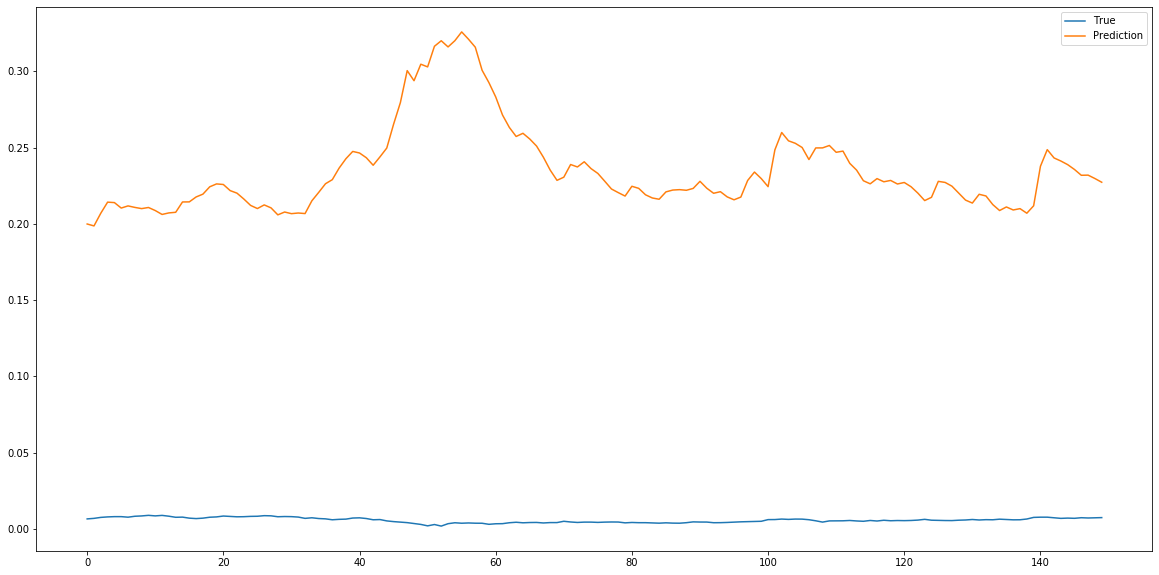

In [16]:
pred = best_model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()